# Classification playground

Put your imports here.

In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import sqlite3
from datetime import datetime as dt

from dataset_util import uci_mhealth, uci_pamap2
from dataset_util.extract_input_features import all_feature, extract_features
import matplotlib.pyplot as plt
from dataset_util import preprocess

from config import SQLITE_DATABASE_FILE
from evaluate_classification import evaluation_metrics
from scikitplot.metrics import plot_confusion_matrix, plot_roc

from misc import mul_str_arr

Load dataset from sqlite database.

Make sure you have downloaded the raw datasets and loaded them into the database by running:
```
python rawdataset.py
python load_dataset.py
```

In [2]:
with sqlite3.connect(SQLITE_DATABASE_FILE) as conn:
    # features = pd.read_sql_query(uci_mhealth.raw_table_valid_data_query, conn)
    global data, subject_ids, activity_ids
    data = pd.read_sql_query(uci_mhealth.raw_table_query_shared_data, conn)
#     data = pd.read_sql_query(uci_pamap2.raw_table_query_shared_data, conn)
#     sliding_windows = uci_mhealth.to_sliding_windows(conn)
    subject_ids = uci_mhealth.get_subject_ids(conn)
    activity_ids = uci_mhealth.get_activity_ids(conn)
    activity_ids.sort()
#     subject_ids = uci_pamap2.get_subject_ids(conn)
#     activity_ids = uci_pamap2.get_activity_ids(conn)
#     activity_ids.sort()

Now we can play with it.

features extracted
training set and test set ready
training set: (2380, 406)
test set: (1047, 406)

classifier result
--------------------------------------------------
activity  1.0
sensitivity:	 99.89539748953975
specificity:	 100.0
auc:	 1.0
--------------------------------------------------
activity  2.0
sensitivity:	 100.0
specificity:	 98.91304347826087
auc:	 1.0
--------------------------------------------------
activity  3.0
sensitivity:	 100.0
specificity:	 100.0
auc:	 1.0
--------------------------------------------------
activity  4.0
sensitivity:	 99.68553459119497
specificity:	 100.0
auc:	 1.0
--------------------------------------------------
activity  5.0
sensitivity:	 100.0
specificity:	 96.73913043478261
auc:	 1.0
--------------------------------------------------
activity  6.0
sensitivity:	 99.79057591623037
specificity:	 100.0
auc:	 0.9998748008194855
--------------------------------------------------
activity  7.0
sensitivity:	 100.0
specificity:	 100.0
auc:	 1.0
--

/usr/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


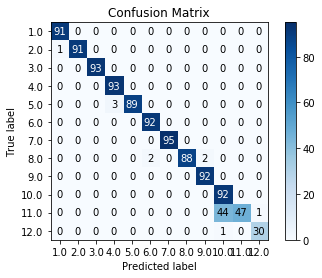

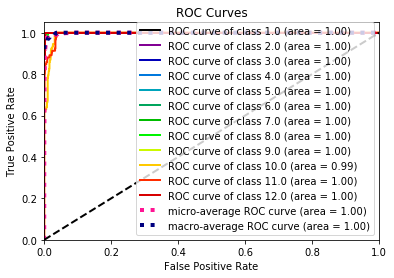

In [4]:
TRAINING_SET_PROPORTION = 0.7

data.drop(labels="timestamp", axis=1)

# only use norms, discard all directional info
for sens in ["chest_acc"] + mul_str_arr(["left_ankle", "right_lower_arm"], ["acc", "gyro", "magn"]):
    cols = data.loc[:, "{}_x".format(sens):"{}_z".format(sens)].values
    norms = np.linalg.norm(cols, axis=1)
#     data.drop(labels=mul_str_arr([sens], ["x","y","z"]), axis=1)
    data.insert(loc=len(data.columns), column="{}_magnitude".format(sens), value=norms)
    
# for sens in ["chest_acc"] + mul_str_arr(["ankle", "hand"], ["acc", "gyro", "magn"]):
#     cols = data.loc[:, "{}_x".format(sens):"{}_z".format(sens)].values
#     norms = np.linalg.norm(cols, axis=1)
#     data.drop(labels=mul_str_arr([sens], ["x","y","z"]), axis=1)
#     data.insert(loc=len(data.columns), column="{}_magnitude".format(sens), value=norms)

sliding_windows = preprocess.full_df_to_sliding_windows(data)

features = extract_features(sliding_windows, all_feature)
print("features extracted")

n_subs = len(subject_ids)
n_training = round(n_subs * TRAINING_SET_PROPORTION)
# n_test = n_subs - n_training
idx = np.isin(features.loc[:,"subject_id"], subject_ids[:n_training])
training_set = features[idx]
test_set = features[np.logical_not(idx)]
train_X, train_y, _ = preprocess.to_classification(training_set)
test_X, test_y, _ = preprocess.to_classification(test_set)
print("training set and test set ready")
print("training set:", np.shape(train_X))
print("test set:", np.shape(test_X))

clsf = RandomForestClassifier(n_estimators=500, class_weight="balanced", n_jobs=-1)
clsf.fit(train_X,train_y)
RF_pred = clsf.predict(test_X)
pred_probability = clsf.predict_proba(test_X)

evaluation_metrics(test_y,RF_pred, pred_probability)

plot_confusion_matrix(test_y, RF_pred)
plot_roc(test_y, pred_probability)